# MIS780 Advanced AI For Business - Assignment 2 - T2 2022

## Demonstrative Example Number 3:  Recurrent Neural network - MasterCard Stock Price Prediction Using LSTM & GRU

**Student Name:** SHIFAT ADBULLAH        
**Student ID:** 220144552

## Table of Content
   
1. [Data Description](#cell_Preparation)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Model Construction](#cell_model)

4. [Model Execution](#cell_execution)
 
5. [Experiments Report](#cell_report)



## Executive Summary

RNN remembers past inputs due to an internal memory which is useful for predicting stock prices, generating text, transcriptions, and machine translation.In the traditional neural network, the inputs and the outputs are independent of each other, whereas the output in RNN is dependent on prior elementals within the sequence. Recurrent networks also share parameters across each layer of the network.

The business problem which we are trying address here is Predicting the MasterCard Stock Price Using LSTM & GRU.

First we will analyze data, preprocess the data to train it on advanced RNN models, and finally evaluate the results.



<a id = "cell_Preparation"></a>
## 1. Data Description

First we will import the MasterCard dataset by adding the Date column to the index and converting it to DateTime format. We will also drop irrelevant columns from the dataset as we are only interested in stock prices, volume, and date. The dataset has Date as index and Open, High, Low, Close, and Volume as columns.

In [22]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(200)
np.random.seed(200)

In [23]:
dataset = pd.read_csv(
    "Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]
).drop(["Dividends", "Stock Splits"], axis=1)
print(dataset.head())

                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


In [24]:
print(dataset.describe())

              Open         High          Low        Close        Volume
count  3872.000000  3872.000000  3872.000000  3872.000000  3.872000e+03
mean    104.896814   105.956054   103.769349   104.882714  1.232250e+07
std     106.245511   107.303589   105.050064   106.168693  1.759665e+07
min       3.748967     4.102467     3.739664     4.083861  6.411000e+05
25%      22.347203    22.637997    22.034458    22.300391  3.529475e+06
50%      70.810079    71.375896    70.224002    70.856083  5.891750e+06
75%     147.688448   148.645373   146.822013   147.688438  1.319775e+07
max     392.653890   400.521479   389.747812   394.685730  3.953430e+08


We use High column to train the model. We can also choose Close or Open columns for a model feature, but High makes more sense as it provides us information of how high the values of the share went on the given day. The minimum stock price is $4.10, and the highest is $400.5. The mean is at 105.9  and the standard deviation 107.3, which means that stocks have high variance.

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

We can see that this dataset does not have any null values. 

In [25]:
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Our test dataset consists of two years, from 2020 to 2022, and the rest of the dataset is used for training.

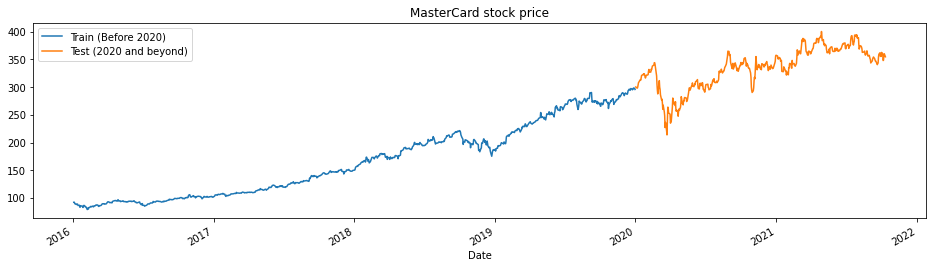

In [42]:
tstart = 2016
tend = 2019

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

In [43]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)

We will use the MinMaxScaler function to standardize our training set, which will help us avoid the outliers or anomalies

In [44]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [45]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [46]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

<a id = "cell_model"></a>
## 3. Model Construction

The model consists of a single hidden layer of LSTM and an output layer.The more units will give us better results. For this experiment, we will set LSTM units to 125, tanh as activation, and set input size.Tensorflow library is user-friendly, so we don't have to create LSTM or GRU models from scratch. We will simply use the LSTM or GRU modules to construct the model. Finally, we will compile the model with an RMSprop optimizer and mean square error as a loss function.



In [47]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 125)               63500     
                                                                 
 dense_4 (Dense)             (None, 1)                 126       
                                                                 
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


The model will train on 50 epochs with 32 batch sizes. You can change the hyperparameters to reduce training time or improve the results. The model training was successfully completed with the best possible loss.

In [48]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
30/30 [==============================] - 4s 59ms/step - loss: 0.0144
Epoch 2/50
30/30 [==============================] - 2s 59ms/step - loss: 0.0030
Epoch 3/50
30/30 [==============================] - 2s 59ms/step - loss: 0.0016
Epoch 4/50
30/30 [==============================] - 2s 60ms/step - loss: 0.0020
Epoch 5/50
30/30 [==============================] - 2s 68ms/step - loss: 0.0013
Epoch 6/50
30/30 [==============================] - 2s 61ms/step - loss: 0.0010
Epoch 7/50
30/30 [==============================] - 2s 59ms/step - loss: 0.0012
Epoch 8/50
30/30 [==============================] - 2s 60ms/step - loss: 8.5141e-04
Epoch 9/50
30/30 [==============================] - 2s 59ms/step - loss: 0.0011
Epoch 10/50
30/30 [==============================] - 2s 59ms/step - loss: 7.9734e-04
Epoch 11/50
30/30 [==============================] - 2s 60ms/step - loss: 8.5478e-04
Epoch 12/50
30/30 [==============================] - 2s 60ms/step - loss: 7.6442e-04
Epoch 13/50
30/30 [==

<a id = "cell_execution"></a>
## 4. Model Execution

In [49]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [50]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

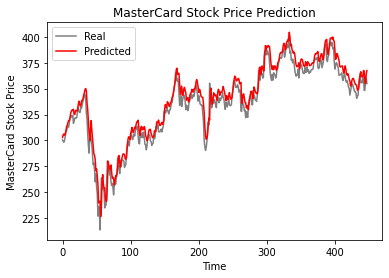

In [51]:
plot_predictions(test_set,predicted_stock_price)

In [52]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 9.24.


**GRU Model** 

We are going to keep everything the same and just replace the LSTM layer with the GRU layer to properly compare the results. The model structure contains a single GRU layer with 125 units and an output layer.

In [53]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 125)               48000     
                                                                 
 dense_5 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48,126
Trainable params: 48,126
Non-trainable params: 0
_________________________________________________________________


In [54]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
30/30 [==============================] - 4s 53ms/step - loss: 0.0311
Epoch 2/50
30/30 [==============================] - 2s 53ms/step - loss: 0.0021
Epoch 3/50
30/30 [==============================] - 2s 53ms/step - loss: 0.0016
Epoch 4/50
30/30 [==============================] - 2s 76ms/step - loss: 0.0014
Epoch 5/50
30/30 [==============================] - 2s 60ms/step - loss: 9.1270e-04
Epoch 6/50
30/30 [==============================] - 2s 53ms/step - loss: 9.0105e-04
Epoch 7/50
30/30 [==============================] - 2s 53ms/step - loss: 0.0010
Epoch 8/50
30/30 [==============================] - 2s 51ms/step - loss: 6.8955e-04
Epoch 9/50
30/30 [==============================] - 2s 54ms/step - loss: 8.4543e-04
Epoch 10/50
30/30 [==============================] - 2s 53ms/step - loss: 7.3059e-04
Epoch 11/50
30/30 [==============================] - 2s 52ms/step - loss: 5.6285e-04
Epoch 12/50
30/30 [==============================] - 2s 53ms/step - loss: 6.5156e-04
Epoch 13/

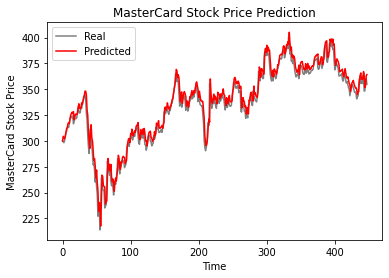

In [55]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

In [56]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 7.46.


<a id = "cell_report"></a>
## 5. Experiments Report

*Provide a summary of experimental results (e.g. tables, figures, charts).*

*Explain the meaning of your result and how your model can be used to address the related business problem.*
 

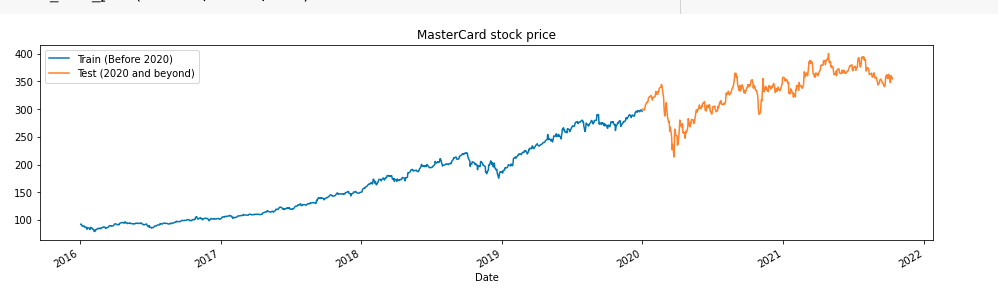

## **LSTM MODEL**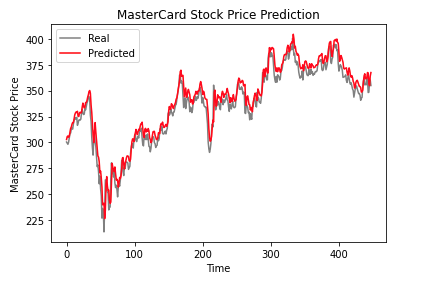

**GRU MODEL**     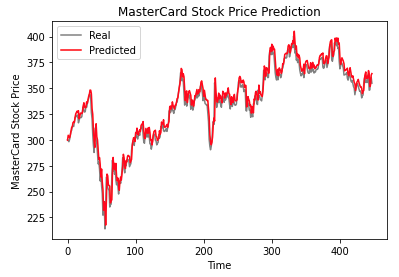

The above results clearly show that the GRU model performed better than LSTM, with a similar structure and hyperparameters. 

Above we tried to solve the business problem which is to predict the stock prices of the Master card using two different recurrent neural network models one is LSTM and Other one is GRU model.

The first graph shows the data plot of the actual datasetf rom 2016 to 2021. And later With the LSTM model we can see that the root mean square error is 9.24 which is a bit hgiht compared to the other model which is GRU model. GRU model got the root mean squared error of 7.46

References: https://www.datacamp.com/tutorial